In [139]:
#import required packages
#basics
import pandas as pd 
import numpy as np
import csv

#misc
import gc
import time
import warnings

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
# import matplotlib_venn as venn

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [111]:
st_words = stopwords.words('english')

In [124]:
hate_speech = pd.read_csv('../resource/train/hate_speech_kaggle_train.txt',sep='\t', names=['id','label','text'])

In [125]:
offensive_speech = pd.read_csv('../resource/train/offensive_train.txt',sep='\t', names=['id','label','text'])

In [126]:
harrassment_speech = pd.read_csv('../resource/train/onlineHarassmentDataset.txt', sep='\t', names=['id','label','text'])

In [127]:
toxic_speech = pd.read_csv('../resource/train/kaggle_toxic_train.csv')
toxic_speech['text'] = toxic_speech['comment_text']

toxic = toxic_speech.loc[(toxic_speech['toxic']==1) | (toxic_speech['severe_toxic']==1) | (toxic_speech['obscene']==1) | (toxic_speech['threat']==1) | (toxic_speech['insult']==1)| (toxic_speech['identity_hate']==1),['id','text']]
normal = toxic_speech.loc[(toxic_speech['toxic']==0) & (toxic_speech['severe_toxic']==0) & (toxic_speech['obscene']==0) & (toxic_speech['threat']==0) & (toxic_speech['insult']==0) & (toxic_speech['identity_hate']==0),['id','text']]


toxic['label'] = 1
normal['label'] = 0

toxic_speech = pd.concat([toxic,  normal])

In [128]:
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")

,id,label,text
0,ID,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,ID,0,momma said no pussy cats inside my doghouse
2,ID,0,@Addicted2Guys: -SimplyAddictedToGuys http://t...
3,ID,0,"@AllAboutManFeet: http://t.co/3gzUpfuMev"" woof..."
4,ID,0,@Allyhaaaaa: Lemmie eat a Oreo &amp; do these ...


In [130]:
datasets = {}

datasets['hate_speech'] = hate_speech
datasets['offensive data']= offensive_speech
datasets['harassment data']= harrassment_speech
datasets['toxic_speech']=toxic_speech

datasets['total'] = pd.concat(datasets.values())

for k,v in datasets.items():
    print(k, len(v))

hate_speech 9507
offensive data 117106
harassment data 20348
toxic_speech 159571
total 306532


In [131]:
df = datasets.get('total')

In [133]:
df['text']=[' '.join([f for f in str(t).split(' ') if not f.startswith('http')]) for t in df['text']]

In [135]:
df['text']=[' '.join([f for f in str(t).split('\n')]) for t in df['text']]

[]

In [144]:
df.to_csv('../resource/train/total.txt', sep='\t', encoding='utf-8', header=None, index=None, columns=['id','label','text'])

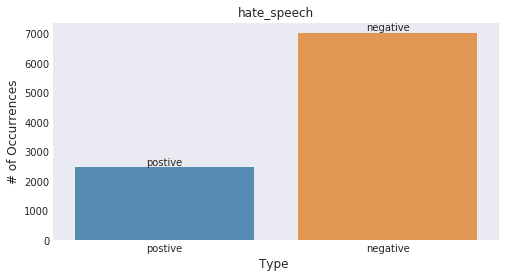

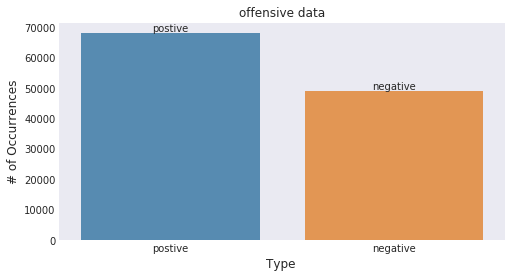

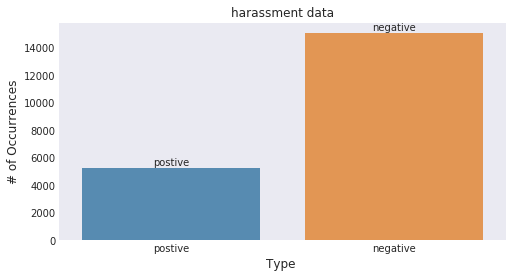

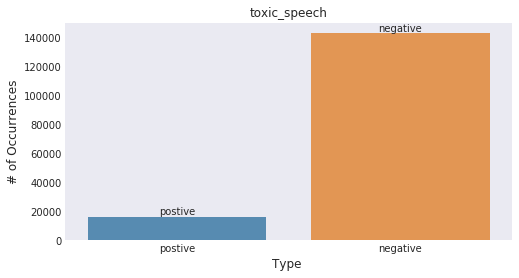

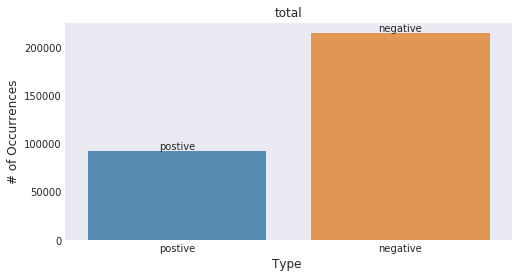

In [9]:
for k,v in datasets.items():
    x=[v['label'].sum(),len(v)-v['label'].sum()]
    
    #plot
    plt.figure(figsize=(8,4))
    ax= sns.barplot(['postive','negative'], x, alpha=0.8)
    plt.title(k)
    plt.ylabel('# of Occurrences', fontsize=12)
    plt.xlabel('Type ', fontsize=12)
    #adding the text labels
    rects = ax.patches
    labels = ['postive','negative']
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

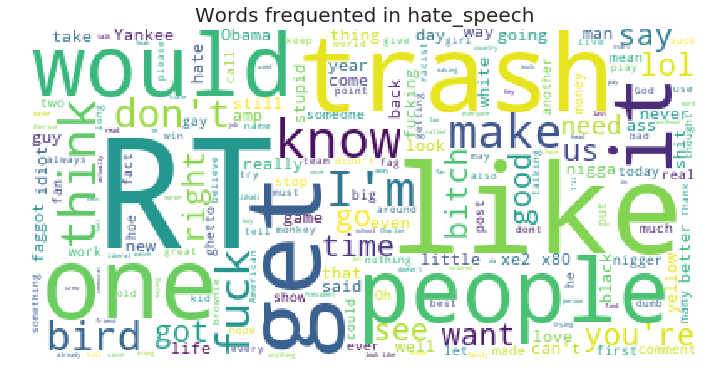

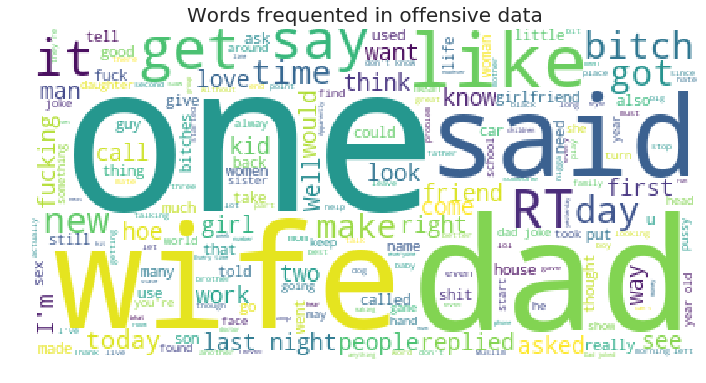

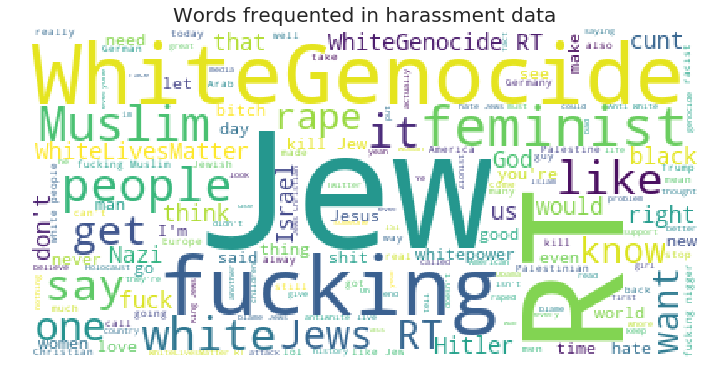

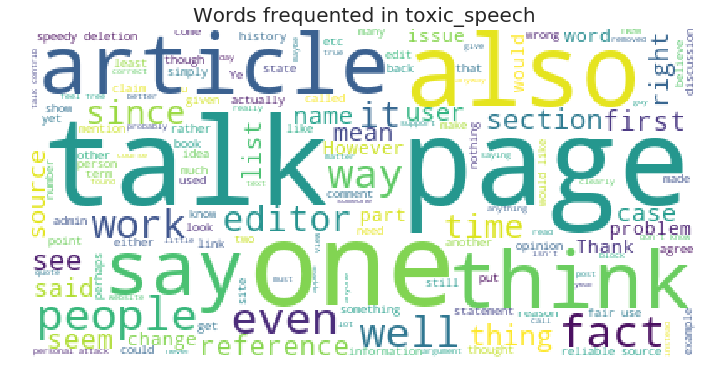

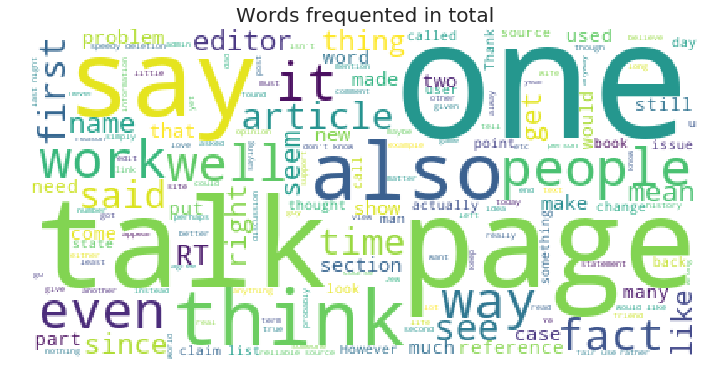

In [10]:
for k,v in datasets.items():
#     print(k)
    v['text']=[' '.join([f for f in str(t).split(' ') if not f.startswith('http')]) for t in v['text']]
        
    
    text=' '.join(v['text'])
    wc= WordCloud(background_color="white",max_words=200,stopwords=st_words)
    wc.generate(text)
    plt.figure(figsize=(12,8))
    plt.axis("off")
    plt.title("Words frequented in " + k, fontsize=20)
    plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

In [11]:
df = datasets.get('total')

In [11]:
df['count_sent']=df["text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["text"].apply(lambda x: len(str(x).split(' ')))
#Unique word count
df['count_unique_word']=df["text"].apply(lambda x: len(set(str(x).split(' '))))
#Letter count
df['count_letters']=df["text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split(' ') if w in st_words]))
#Average length of the words
df["mean_word_len"] = df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split(' ')]))

/home/striker/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


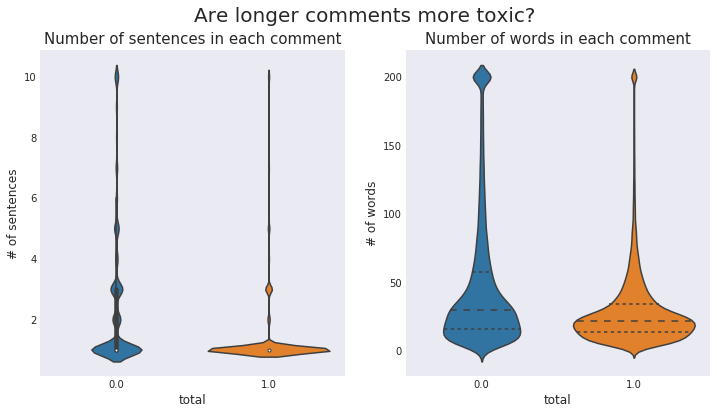

In [12]:
df['count_sent'].loc[df['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='label', data=df, split=True)

plt.xlabel('total', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("Number of sentences in each comment", fontsize=15)
# words
df['count_word'].loc[df['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='label', data=df,split=True,inner="quart")

plt.xlabel('total', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("Number of words in each comment", fontsize=15)

plt.show()

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [12]:
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

df['text']=[' '.join([f for f in str(t).split(' ') if not f.startswith('http')]) for t in df['text']]

tfv.fit(df['text'])
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(df['text'])

In [56]:
train_unigrams.shape, len(df['text'])

((306532, 4228), 306532)

In [63]:
toxic_ids = df.index[df['label']==1]
non_toxic_ids = df.index[df['label']==0]

In [101]:
from operator import itemgetter
from collections import  Counter

c = Counter()
c.max_features = 100

words = []

for doc in toxic_ids:
    feature_index = train_unigrams[doc,:].nonzero()[1]
    tfidf_scores = sorted(zip(feature_index, [train_unigrams[doc, x] for x in feature_index]),key=itemgetter(1))
    top_n_words = [w for w, s in [(features[i], s) for (i, s) in tfidf_scores]][-5:]
    
    if(len(top_n_words)>0):
        c.update(top_n_words)
        


AttributeError: 'Counter' object has no attribute 'fit'

In [102]:
c.most_common(100)


[('bitch', 3773),
 ('rt', 2973),
 ('trash', 1937),
 ('said', 1815),
 ('like', 1708),
 ('dad', 1682),
 ('wife', 1624),
 ('fuck', 1465),
 ('bitches', 1454),
 ('pussy', 1239),
 ('hoes', 1219),
 ('got', 1190),
 ('just', 1155),
 ('8220', 1144),
 ('black', 1143),
 ('fucking', 1134),
 ('hoe', 1121),
 ('sex', 1111),
 ('girlfriend', 1111),
 ('8221', 1092),
 ('don', 1071),
 ('ass', 1068),
 ('shit', 1059),
 ('lol', 1046),
 ('128514', 1026),
 ('nigga', 1020),
 ('love', 934),
 ('bird', 915),
 ('women', 881),
 ('faggot', 866),
 ('man', 863),
 ('white', 845),
 ('fat', 791),
 ('hate', 787),
 ('girl', 779),
 ('people', 755),
 ('know', 755),
 ('amp', 749),
 ('night', 736),
 ('woman', 725),
 ('day', 721),
 ('8230', 708),
 ('ve', 680),
 ('ain', 677),
 ('yankees', 677),
 ('gay', 672),
 ('mate', 672),
 ('son', 654),
 ('jews', 640),
 ('nigger', 625),
 ('charlie', 623),
 ('today', 621),
 ('niggas', 620),
 ('kids', 619),
 ('did', 617),
 ('baby', 610),
 ('yellow', 602),
 ('girls', 598),
 ('really', 595),
 ('tol

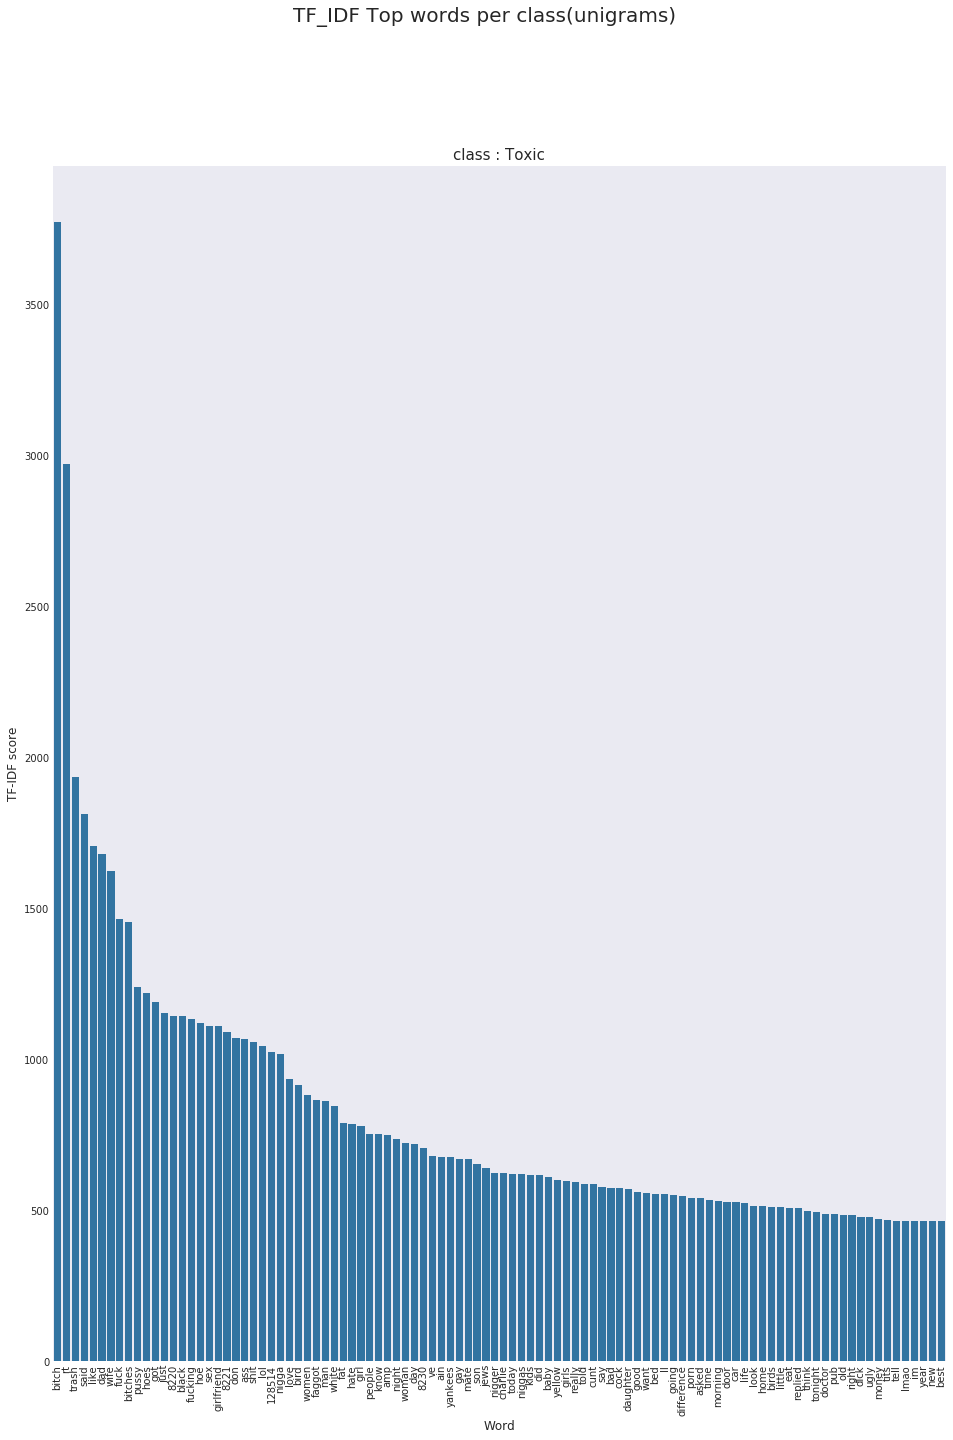

In [104]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plot = sns.barplot([v[0] for v in c.most_common(100)],[v[1] for v in c.most_common(100)],color=color[0],orient='v')

plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Count score', fontsize=12)

plt.show()

In [108]:
df.tail(4)

,ID,id,label,text
159567,NaN,ffea4adeee384e90,0.0,You should be ashamed of yourself \n\nThat is ...
159568,NaN,ffee36eab5c267c9,0.0,"Spitzer \n\nUmm, theres no actual article for ..."
159569,NaN,fff125370e4aaaf3,0.0,And it looks like it was actually you who put ...
159570,NaN,fff46fc426af1f9a,0.0,"""\nAnd ... I really don't think you understand..."
